<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/Slab_generation_and_warmstart_Unsuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCP pretrained models for warmstart
written by S.Choung 1th Dec
This code is to test out OC models using OC pretrained models

## OCP installation

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

if not os.path.exists('ocp'):
     !git clone https://github.com/Open-Catalyst-Project/ocp.git
os.chdir('ocp')
!pip install -e .
!pip -q install  lmdb pymatgen==2023.5.10 ase==3.22.1 orjson e3nn==0.2.6 wandb
!pip install submitit

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ocp'...
remote: Enumerating objects: 11841, done.
remote: Counting objects: 100% (2914/2914), done.
remote: Compressing objects: 100% (716/716), done.
remote: Total 11841 (delta 2506), reused 2351 (delta 2197), pack-reused 8927
Receiving objects: 100% (11841/11841), 172.64 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (8158/8158), done.
Obtaining file:///content/ocp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable f

In [3]:
import json,zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

from ase.io import read

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from ocpmodels.datasets import SinglePointLmdbDataset
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.models import CGCNN,SchNet
from ocpmodels.datasets import data_list_collater
from ocpmodels.common.relaxation.ase_utils import OCPCalculator


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")


## load some useful utillities
 code taken from https://open-catalyst-project.github.io/tutorial/fine-tuning/fine-tuning-oxides.html

In [5]:
# @title
import urllib
import os
from pathlib import Path
import requests
# @title
import ocpmodels as om
from pathlib import Path
import subprocess
import sys
import numba
import numpy as np
import ase
import e3nn
import pymatgen.core as pc
import torch
import torch.cuda as tc
import torch_geometric as tg
import platform
import psutil

def ocp_root():
    """Return the root directory of the installed ocp package."""
    return Path(om.__file__).parent.parent

def ocp_main():
    """Return the path to ocp main.py"""
    return ocp_root() / "main.py"

def describe_ocp():
    """Print some system information that could be useful in debugging."""
    print(sys.executable, sys.version)
    print(f'ocp is installed at {ocp_root()}')

    commit_hash = (
            subprocess.check_output(
                    [
                        "git",
                        "-C",
                        om.__path__[0],
                        "describe",
                        "--always",
                    ]
                )
                .strip()
                .decode("ascii")
            )
    print(f'ocp repo is at git commit: {commit_hash}')
    print(f'numba: {numba.__version__}')
    print(f'numpy: {np.version.version}')
    print(f'ase: {ase.__version__}')
    print(f'e3nn: {e3nn.__version__}')
    print(f'pymatgen: {pc.__version__}')
    print(f'torch: {torch.version.__version__}')
    print(f'torch.version.cuda: {torch.version.cuda}')
    print(f'torch.cuda: is_available: {tc.is_available()}')
    if tc.is_available():
        print('  __CUDNN VERSION:', torch.backends.cudnn.version())
        print('  __Number CUDA Devices:', torch.cuda.device_count())
        print('  __CUDA Device Name:',torch.cuda.get_device_name(0))
        print('  __CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
    print(f'torch geometric: {tg.__version__}')
    print()
    print(f'Platform: {platform.platform()}')
    print(f'  Processor: {platform.processor()}')
    print(f'  Virtual memory: {psutil.virtual_memory()}')
    print(f'  Swap memory: {psutil.swap_memory()}')
    print(f'  Disk usage: {psutil.disk_usage("/")}')
checkpoints = {
    # Open Catalyst 2020 (OC20)
    'CGCNN 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_200k.pt',
    'CGCNN 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_2M.pt',
    'CGCNN 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_20M.pt',
    'CGCNN All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_all.pt',
    'DimeNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_200k.pt',
    'DimeNet 2M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_2M.pt',
    'SchNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_200k.pt',
    'SchNet 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_2M.pt',
    'SchNet 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_20M.pt',
    'SchNet All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_all_large.pt',
    'DimeNet++ 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_200k.pt',
    'DimeNet++ 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_2M.pt',
    'DimeNet++ 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_20M.pt',
    'DimeNet++ All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_all.pt',
    'SpinConv 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/spinconv_force_centric_2M.pt',
    'SpinConv All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/spinconv_force_centric_all.pt',
    'GemNet-dT 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/gemnet_t_direct_h512_2M.pt',
    'GemNet-dT All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt',
    'PaiNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_05/s2ef/painn_h512_s2ef_all.pt',
    'GemNet-OC 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_2M.pt',
    'GemNet-OC All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_all.pt',
    'GemNet-OC All+MD'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt',
    'GemNet-OC-Large All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_large_s2ef_all_md.pt',
    'SCN 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t1_b1_s2ef_2M.pt',
    'SCN-t4-b2 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t4_b2_s2ef_2M.pt',
    'SCN All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_all_md_s2ef.pt',
    'eSCN-L4-M2-Lay12 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l4_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_all_md_s2ef.pt',
    'eSCN-L6-M3-Lay20 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt',
    'EquiformerV2 (83M) 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_83M_2M.pt',
    'EquiformerV2 (31M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_31M_ec4_allmd.pt',
    'EquiformerV2 (153M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_153M_ec4_allmd.pt',
    # Open Catalyst 2022 (OC22)
    'GemNet-dT OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gndt_oc22_all_s2ef.pt',
    'GemNet-OC OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt',
    'GemNet-OC OC20+OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_05/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC OC20->OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_finetune_all_s2ef.pt',
    'equiformer' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_10/oc22/s2ef/eq2_121M_e4_f100_oc22_s2ef.pt',
    'pt_ceo2_ce7_ep200' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/fine-tuning/checkpoints/2023-11-14-16-21-20-lr_5e-07_epochs_200/checkpoint.pt',
    'pt_ceo2_ce5_ep100_add' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/additional_data_training/2023-11-16-02-42-08-lr_0.0005_epochs_100/checkpoint.pt',
                }

def list_checkpoints():
    """List checkpoints that are available to download."""
    print('See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.')
    for key in checkpoints:
        print(key)
    print('Copy one of these keys to get_checkpoint(key) to download it.')


def get_checkpoint(key):
    """Download a checkpoint.
    key: string in checkpoints.
    Returns name of checkpoint that was saved.
    """
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception('No url found for {key}')
    print('url',url)
    pt = Path(urllib.parse.urlparse(url).path).name
    print('pt',pt)

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt
from pathlib import Path
import numpy as np
from ase.db import connect

def train_test_val_split(ase_db, ttv=(0.8, 0.1, .1), files=('train.db', 'test.db', 'val.db'), seed=42):
    """Split an ase db into train, test and validation dbs.

    ase_db: path to an ase db containing all the data.
    ttv: a tuple containing the fraction of train, test and val data. This will be normalized.
    files: a tuple of filenames to write the splits into. An exception is raised if these exist.
           You should delete them first.
    seed: an integer for the random number generator seed

    Returns the absolute path to files.
    """

    for db in files:
        if os.path.exists(db):
            raise Exception('{db} exists. Please delete it before proceeding.')

    src = connect(ase_db)
    N = src.count()

    ttv = np.array(ttv)
    ttv /= ttv.sum()

    train_end = int(N * ttv[0])
    test_end = train_end + int(N * ttv[1])

    train = connect(files[0])
    test = connect(files[1])
    val = connect(files[2])

    ids = np.arange(1, N + 1)
    rng = np.random.default_rng(seed=42)
    rng.shuffle(ids)

    for _id in ids[0:train_end]:
        row = src.get(id=int(_id))
        train.write(row.toatoms())

    for _id in ids[train_end:test_end]:
        row = src.get(id=int(_id))
        test.write(row.toatoms())

    for _id in ids[test_end:]:
        row = src.get(id=int(_id))
        val.write(row.toatoms())

    return [Path(f).absolute() for f in files]
# @title
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper
import torch
import os
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
from io import StringIO
import sys
import contextlib

def generate_yml_config(checkpoint_path, yml='run.yml', delete=(), update=()):
    """Generate a yml config file from an existing checkpoint file.

    checkpoint_path: string to path of an existing checkpoint
    yml: name of file to write to.
    pop: list of keys to remove from the config
    update: dictionary of key:values to update

    Use a dot notation in update.

    Returns an absolute path to the generated yml file.
    """

    # You can't just read in the checkpoint with torch. The calculator does some things to it.
    # Rather than recreate that here I just reuse the calculator machinery. I don't want to
    # see the output though, so I capture it.

    with contextlib.redirect_stdout(StringIO()) as _:
        config = OCPCalculator(checkpoint_path=checkpoint_path).config # there seems an parameter checkpoint changed in OCPcalculator (s.choung)

    for key in delete:
        if key in config and len(key.split('.')) == 1:
            del config[key]
        else:
            keys = key.split('.')
            if keys[0] in config:
                d = config[keys[0]]
            else:
                continue
            if isinstance(d, dict):
                for k in keys[1:]:
                    if isinstance(d[k], dict):
                        d = d[k]
                    else:
                        if k in d:
                            del d[k]

    def nested_set(dic, keys, value):
        for key in keys[:-1]:
            dic = dic.setdefault(key, {})
        dic[keys[-1]] = value

    for _key in update:
        keys = _key.split('.')
        nested_set(config, keys, update[_key])


    out = dump(config)
    with open(yml, 'wb') as f:
        f.write(out.encode('utf-8'))

    return Path(yml).absolute()

## Calculator setting




In [6]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
gemnet = get_checkpoint('GemNet-OC OC20+OC22')
calc = OCPCalculator(checkpoint_path=os.path.expanduser(gemnet), cpu=False)

url https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt
pt gnoc_oc22_oc20_all_s2ef.pt


In [9]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
import json
def stoich(data,i):
    data_string =data[i]['reactants']
    prod_string =data[i]['products']
    reactants_list = list(json.loads(data_string).keys())
    values_list = list(json.loads(data_string).values())
    product = list(json.loads(prod_string).keys())
    return values_list, reactants_list, product

def energy_cal(atoms, fmax=0.05):
    atoms.set_calculator(calc)
    tags = np.ones(len(atoms))
    atoms.set_tags(tags)
    print(tags)
    opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()
def status(proceed):
    num = int(proceed/5)
    return '🟩'*num+'⬜️'*(20-num)

## slab generation+Pt anchoring example

In [8]:
!pip install ase pymatgen

## 예쁜 figure그리기

In [10]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (2,109 kB/s)
debconf: unable to initialize frontend: Dialo

In [11]:
from ase import Atoms
from ase.io import Trajectory, write
from ase.build import bulk, surface, molecule, add_adsorbate, fcc111
from ase.constraints import ExpCellFilter, StrainFilter, FixAtoms, FixedPlane, FixBondLength
from ase.optimize import LBFGS, BFGS, FIRE
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.md import MDLogger
from ase.io.vasp import read_vasp

import pandas as pd
import ipywidgets as widgets
from IPython.display import display_png, Image as ImageWidget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import shutil

import glob
from pathlib import Path
from PIL import Image, ImageDraw

from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.vasp import Poscar
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor

import numpy as np
from scipy.spatial.distance import cdist

def visual(structure, index, max_size=(100, 100), stretch_y=1.0):
    renderer = write('./temp.pov', structure, rotation='90z,-90x')
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)
    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)

Atoms(symbols='Fe48O72', pbc=True, cell=[[10.183804097133027, 0.0, 6.235781545348832e-16], [-5.091902048566513, 8.819433055281252, 6.235781545348832e-16], [0.0, 0.0, 41.32289296047725]], bulk_equivalent=..., bulk_wyckoff=..., constraint=FixAtoms(indices=[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 72, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]))


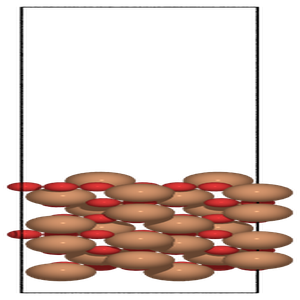

Atoms(symbols='Fe48O72', pbc=True, cell=[[10.183804097133027, 0.0, 6.235781545348832e-16], [-5.091902048566513, 8.819433055281252, 6.235781545348832e-16], [0.0, 0.0, 41.32289296047725]], bulk_equivalent=..., bulk_wyckoff=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 72, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]))


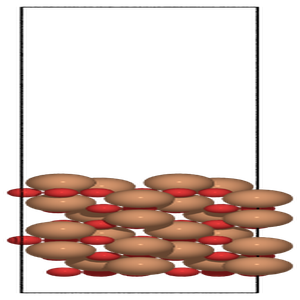

Atoms(symbols='Fe36O54', pbc=True, cell=[[4.409716527640626, 0.0, -2.5459510242832555], [-8.434324765926193e-16, 13.774297653492416, 8.434324765926193e-16], [0.0, 0.0, 35.64331433996559]], bulk_equivalent=..., bulk_wyckoff=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 37, 39, 43, 45, 50, 51, 52, 54, 55, 57, 58, 59]))


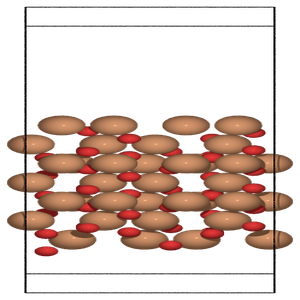

Atoms(symbols='Fe36O54', pbc=True, cell=[[4.409716527640626, 0.0, -2.5459510242832555], [-8.434324765926193e-16, 13.774297653492416, 8.434324765926193e-16], [0.0, 0.0, 35.64331433996559]], bulk_equivalent=..., bulk_wyckoff=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 37, 39, 42, 43, 45, 48, 50, 52, 53, 55, 57, 58, 59]))


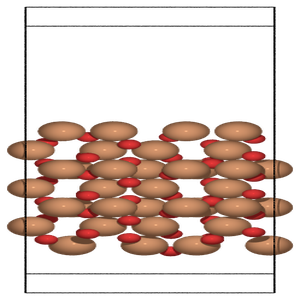

In [24]:
from pymatgen.io.vasp import Poscar
import os
import sys
import re, glob
import shutil
import time
import math
import numpy as np
from os import listdir
from os.path import isfile, join, isdir, expanduser, basename
from tabulate import tabulate
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import Lattice, SlabGenerator, Structure, generate_all_slabs
from pymatgen.io.vasp.inputs import Poscar
from pymatgen.io.ase import AseAtomsAdaptor
from ase.constraints import FixAtoms

def slab_generation_fun(bulk,facet,supercell_size,thick):
    slabgen = SlabGenerator(bulk, facet, thick, 15) #miller, min-slab size, vaccum size in angstroms
    all_slabs = slabgen.get_slabs()
    for slabs in all_slabs:
      slabs.make_supercell(supercell_size)
    #print(f"The {facet} slab only has %s termination." % (len(all_slabs)))
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in all_slabs] # ase transformation
    for idx,slab_atoms in enumerate(slab_atoms_list):
      slab=slab_atoms.copy()
      min_pos_z = np.min(slab.positions, axis=0)[2]
      slab.set_positions(slab.positions - [0, 0, min_pos_z-3])
      # fix atoms half
      ase_slab_z_positions=[atom.position[2] for atom in slab]
      c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] <np.median(ase_slab_z_positions)])
      slab.set_constraint(c)
      print(slab)
      visual(slab, './', (300, 300),1)
      write(f'/content/drive/MyDrive/for_woonsuk/test_{idx}_{facet}.vasp',slab)

    return slab_atoms_list

##########Bulk 넣기############
temp = Poscar.from_file("/content/drive/MyDrive/for_woonsuk/Fe2O3 (2).poscar")
ceo2_bulk = temp.structure
supercell_size=[[2,2,1], [1,1,1]]
facets = [(0,0,1), (1,0,0)]
thickness = [8, 12]
##############################
slab_list_list=[]
for idx,facet in enumerate(facets):
  slab_list = slab_generation_fun(ceo2_bulk,facets[idx],supercell_size[idx],thickness[idx])
  slab_list_list.append(slab_list)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
       Step     Time          Energy         fmax
LBFGS:    0 05:06:57     -766.393799        4.0703
LBFGS:    1 05:06:57     -770.606689        3.4331
LBFGS:    2 05:06:58     -773.461975        1.9074
LBFGS:    3 05:06:58     -774.556763        0.9135
LBFGS:    4 05:06:58     -775.174988        0.7295
LBFGS:    5 05:06:58     -775.382446        0.7090
LBFGS:    6 05:06:58     -775.456665        0.6072
LBFGS:    7 05:06:58     -775.537537        0.1664
LBFGS:    8 05:06:58     -775.850708        0.1217
LBFGS:    9 05:06:58     -775.966675        0.0913
LBFGS:   10 05:06:58     -776.033386        0.0946
LBFGS:   11 05:06:59   

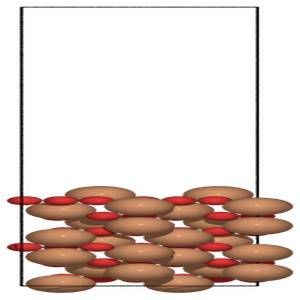

========after========


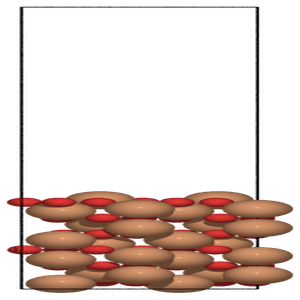

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
       Step     Time          Energy         fmax
LBFGS:    0 05:07:01     -746.685486        2.3165
LBFGS:    1 05:07:01     -747.748108        2.0869
LBFGS:    2 05:07:01     -753.438782        0.9534
LBFGS:    3 05:07:01     -754.548035        1.0488
LBFGS:    4 05:07:01     -755.621948        1.1471
LBFGS:    5 05:07:01     -756.376770        0.6957
LBFGS:    6 05:07:01     -756.669617        0.6795
LBFGS:    7 05:07:01     -755.947876        0.5061
LBFGS:    8 05:07:01     -756.042480        0.3675
LBFGS:    9 05:07:02     -756.473877        0.3107
LBFGS:   10 05:07:02     -756.729065        0.2587
LBFGS:   11 05:07:02   

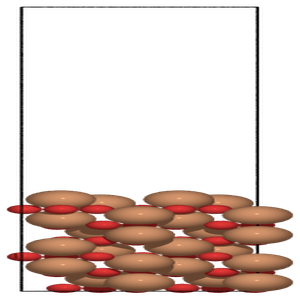

========after========


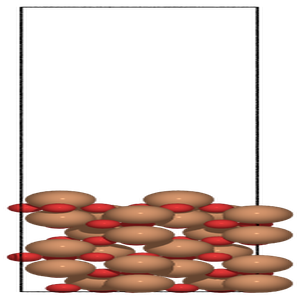

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
       Step     Time          Energy         fmax
LBFGS:    0 05:07:05     -569.696350        2.4924
LBFGS:    1 05:07:05     -571.430115        2.1771
LBFGS:    2 05:07:05     -573.929932        1.9731
LBFGS:    3 05:07:05     -574.796692        1.1672
LBFGS:    4 05:07:05     -574.816467        0.7519
LBFGS:    5 05:07:06     -575.383240        0.8008
LBFGS:    6 05:07:06     -575.584961        0.6963
LBFGS:    7 05:07:06     -575.897461        0.4189
LBFGS:    8 05:07:06     -576.042664        0.3892
LBFGS:    9 05:07:06     -576.028198        0.4519
LBFGS:   10 05:07:06     -576.017212        0.3840
LBFGS:   11 05:07:06     -576.156616        0.1948
LBFGS:   12 05:07:06     -576.261902        0.1498
LBFGS:   13 

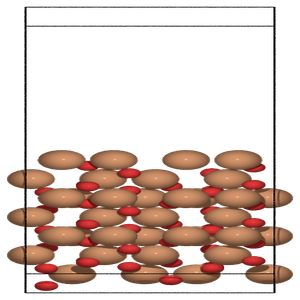

========after========


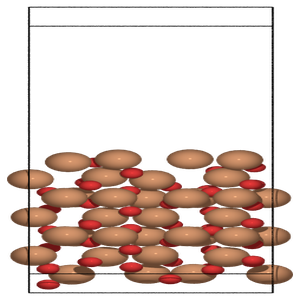

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
       Step     Time          Energy         fmax
LBFGS:    0 05:07:09     -574.706482        2.7848
LBFGS:    1 05:07:10     -576.739136        2.4636
LBFGS:    2 05:07:10     -579.165466        2.5631
LBFGS:    3 05:07:10     -579.606140        0.9219
LBFGS:    4 05:07:10     -579.970398        0.7593
LBFGS:    5 05:07:10     -580.398071        0.8865
LBFGS:    6 05:07:10     -580.542236        0.7102
LBFGS:    7 05:07:10     -580.784058        0.3849
LBFGS:    8 05:07:10     -580.784912        0.3397
LBFGS:    9 05:07:10     -581.026672        0.4121
LBFGS:   10 05:07:10     -581.025879        0.3427
LBFGS:   11 05:07:11     -580.998169        0.2356
LBFGS:   12 05:07:11     -581.013794        0.2337
LBFGS:   13 

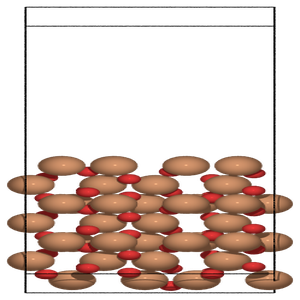

========after========


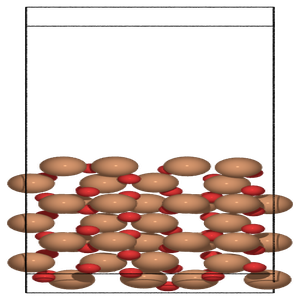

In [26]:
for idx,slab_list in enumerate(slab_list_list):
  for idx2,slab in enumerate(slab_list):
    atoms = slab.copy()
    tags = np.ones(len(atoms))
    atoms.set_tags(tags)
    atoms.set_calculator(calc)
    tot_energy = energy_cal(atoms, fmax=0.05)  # Adjust fmax as needed
    print(f'========before========')
    visual(slab, './', (300, 300),1)
    print(f'========after========')
    visual(atoms, './', (300, 300),1)
    write(f'/content/drive/MyDrive/for_woonsuk/test_termination{idx2}_{facets[idx]}_relaxed.vasp',atoms)


### anchoring 방벙

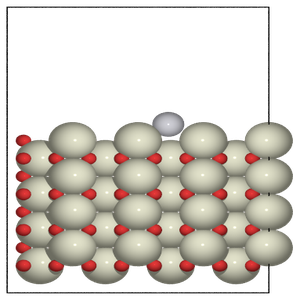

In [ ]:
from ase.build import add_adsorbate
from ase import build, Atom

ceo2_list=[]
O_poisitions=[6.89422,6.96420,16.78838]
delta_position=[0, 1.6, 1.8]
a = Atom('Pt')
a.position= a.position +  O_poisitions + delta_position
slab110=slab110 + a
visual(slab110, './', (300, 300),1)
#get_opt_energy(slab)
#write(f'./test{i}.vasp',slab) # 이런식으로 vasp format으로 저장도 가능
ceo2_list.append(slab110)
#write('./input/ceo2_list.traj',ceo2_list)# 이런식으로 traj format으로 저장도 가능. ASE에서는 traj쓰는거 추천


after MLP relaxation

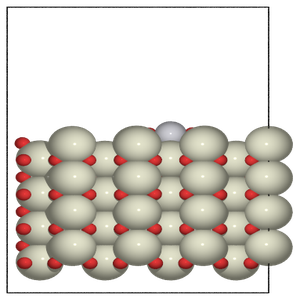

In [ ]:
visual(slab110, './', (300, 300),1)

Vacancy 만드는 방법

In [ ]:
#del slab[index]  # index는 vacancy 만들고싶은 아톰의 index 아래는 지우는 예시
'''
o_indices = [atom.index for atom in slab if atom.symbol == 'O']
z_values = [slab[o_index].position[2] for o_index in o_indices]
sorted_indices = sorted(range(len(z_values)), key=lambda i: z_values[i], reverse=True)
get_five_percent=int(len(ce_indices)*2*0.05)
z_max_indices = [o_indices[i] for i in sorted_indices[:get_five_percent]]
del slab[z_max_indices]
_1B3_traj.append(slab)
visual(slab, './', (300, 300),1)
print(slab)'''